In [1]:
# load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as api
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from datetime import datetime
from scipy import signal
import warnings

# load Medical Dataset
medical = pd.read_csv('medical_time_series .csv')

In [2]:
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Explore the data
print(medical.shape)
print(medical.head())
print(medical.info())

(731, 2)
   Day   Revenue
0    1  0.000000
1    2 -0.292356
2    3 -0.327772
3    4 -0.339987
4    5 -0.124888
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB
None


In [4]:
medical.describe

<bound method NDFrame.describe of      Day    Revenue
0      1   0.000000
1      2  -0.292356
2      3  -0.327772
3      4  -0.339987
4      5  -0.124888
..   ...        ...
726  727  15.722056
727  728  15.865822
728  729  15.708988
729  730  15.822867
730  731  16.069429

[731 rows x 2 columns]>

In [5]:
# Generate a date range starting from January 1, 2015
medical['Date'] = pd.date_range(start=datetime(2015, 1, 1), periods=medical.shape[0], freq='D')

# Set 'Date' as the index
medical.set_index('Date', inplace=True)

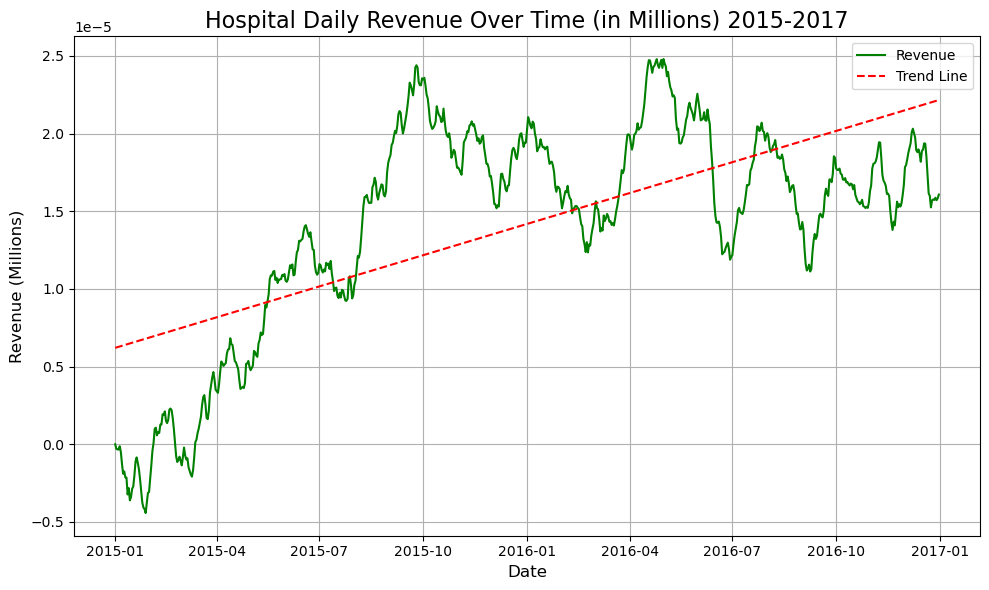

In [6]:
# Visualize the Time Series Data
plt.figure(figsize=(10, 6))

# Plot Revenue (converted to millions) against the Date index
plt.plot(medical.index, medical['Revenue'] / 1e6, color='green', label='Revenue')

# Adding title and labels
plt.title('Hospital Daily Revenue Over Time (in Millions) 2015-2017', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (Millions)', fontsize=12)

# Add a grid
plt.grid(True)

# Create the trend line
x = mdates.date2num(medical.index)  # Convert date to numerical format
y = medical['Revenue'] / 1e6        # Revenue in millions
z = np.polyfit(x, y, 1)             # Fit a first-degree polynomial (linear trend)
p = np.poly1d(z)                    # Create a polynomial object

# Plot the trend line
plt.plot(medical.index, p(x), "r--", label='Trend Line')  # Plot the trend line as a red dashed line
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Clean the data
# Get a count of the NaN
print("\nMissing values per column:")
print(medical.isna().sum())


Missing values per column:
Day        0
Revenue    0
dtype: int64


In [8]:
# Calculate the first difference and drop the resulting NaN values
medical['Revenue_diff'] = medical['Revenue'].diff()

# Remove any NaN or inf values
medical = medical.replace([np.inf, -np.inf], np.nan).dropna(subset=['Revenue_diff'])

In [9]:
# Run the ADF test on the differenced data
adf_test_diff = adfuller(medical['Revenue_diff'])
print(f"ADF Statistic (differenced): {adf_test_diff[0]}")
print(f"p-value (differenced): {adf_test_diff[1]}")

ADF Statistic (differenced): -17.37477230355706
p-value (differenced): 5.1132069788403175e-30


In [10]:
# Split time series into a training set and a test set
train, test = train_test_split(medical, test_size=0.2, shuffle=False, random_state=369)

In [11]:
# Fit ARIMA model with differenced data
model = ARIMA(train['Revenue_diff'].dropna(), order=(1, 0, 0))  # Adjust 'd' based on differencing needed
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           Revenue_diff   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -350.349
Date:                Tue, 08 Oct 2024   AIC                            706.698
Time:                        21:32:06   BIC                            719.808
Sample:                    01-02-2015   HQIC                           711.808
                         - 08-07-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.031      1.063      0.288      -0.028       0.093
ar.L1          0.4079      0.038     10.748      0.000       0.333       0.482
sigma2         0.1943      0.012     15.948      0.0

In [12]:
# Apply ADF test to check stationarity
adf_test = adfuller(medical['Revenue'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

ADF Statistic: -2.2107705835173683
p-value: 0.20235960623322002


In [13]:
# Interpretation of results
if adf_test[1] <= 0.05:
    print("The time series is stationary (Reject null hypothesis).")
else:
    print("The time series is not stationary (Fail to reject null hypothesis).")

The time series is not stationary (Fail to reject null hypothesis).


In [14]:
# Save dataframe to CSV
train.to_csv('task1_train_clean.csv')
test.to_csv('task1_test_clean.csv')

In [15]:
# Check for seasonality by Decompose the data
decomposed_data = seasonal_decompose(medical['Revenue'], model='additive', period=365)

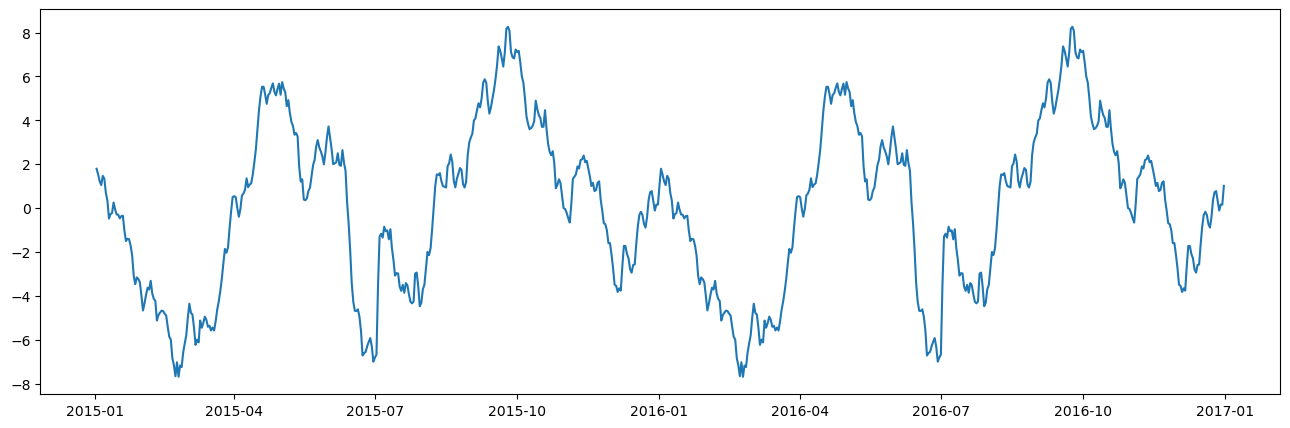

In [16]:
# Plot seasonal component of the data
plt.figure(figsize = [16,5])
plt.plot(decomposed_data.seasonal);

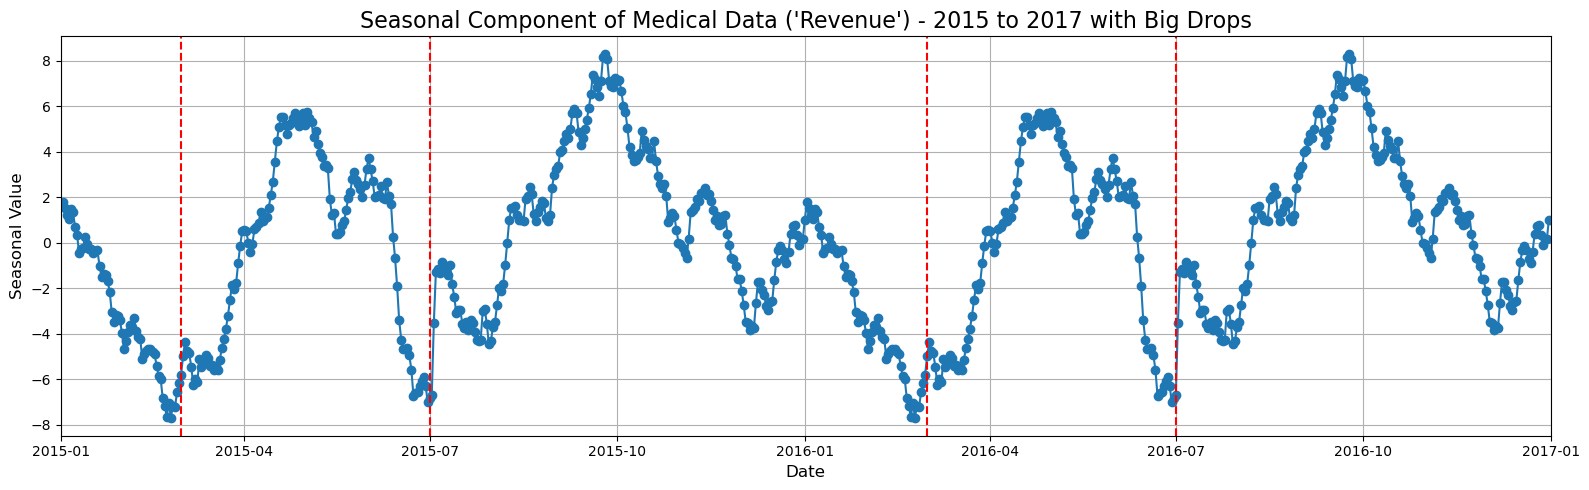

In [17]:
# Decompose the 'Revenue' column using seasonal_decompose
decomposed_data = seasonal_decompose(medical['Revenue'], model='additive', period=365)

# Get the seasonal component
seasonal_component = decomposed_data.seasonal

# Calculate the differences between consecutive points
seasonal_diff = seasonal_component.diff()

# Define a threshold for what constitutes a "big drop"
threshold = seasonal_diff.quantile(0.05)  # This can be adjusted based on how big the drop should be

# Find the indices where the drop exceeds the threshold
big_drops = seasonal_diff[seasonal_diff < threshold].index

# Plot the seasonal component of the decomposition
plt.figure(figsize=[16, 5])

# Plot seasonal component with circular markers
plt.plot(seasonal_component, marker='o', label='Seasonal Component')


# Limit the x-axis to a specific date range (2015-01-01 to 2017-01-01)
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2017-01-01'))

# Draw vertical lines on specific dates: February and July of 2015 and 2016
dates_to_mark = ['2015-03-01', '2015-07-01', '2016-03-01', '2016-07-01']
for date in dates_to_mark:
    plt.axvline(x=pd.to_datetime(date), color='red', linestyle='--', label=f'Marked Date {date}')

# Add title, labels, and grid
plt.title("Seasonal Component of Medical Data ('Revenue') - 2015 to 2017 with Big Drops", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seasonal Value', fontsize=12)
plt.grid(True)

# Display the plot with tight layout
plt.tight_layout()
plt.show()

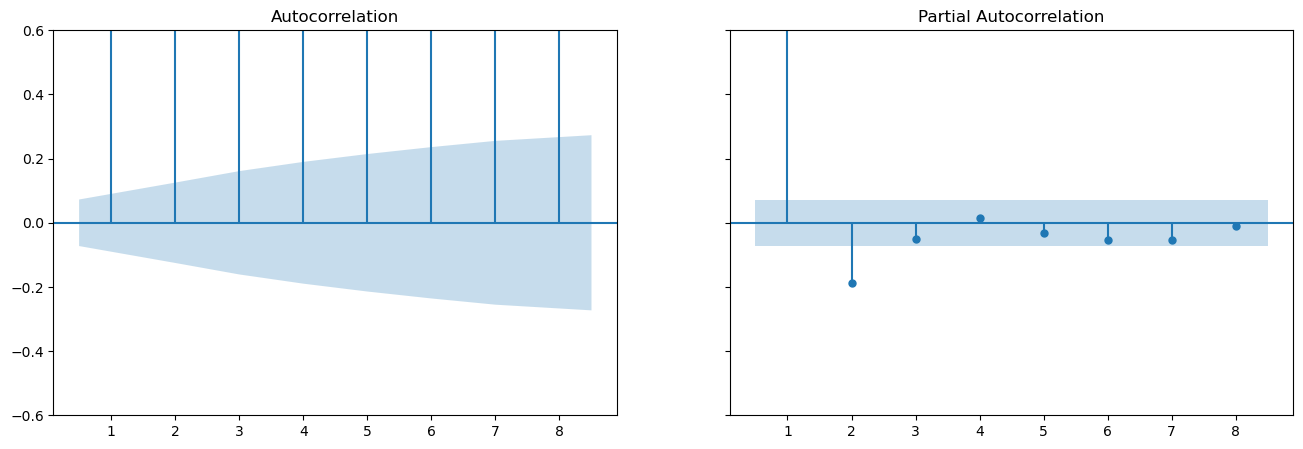

In [18]:
# Plot autocorrelation and partial autocorrelation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 5], sharey=True)
plot_acf(medical['Revenue'], lags=8, zero=False, ax=ax1)
plot_pacf(medical['Revenue'], lags=8, zero=False, ax=ax2)
plt.ylim(-0.6, 0.6)
plt.show()

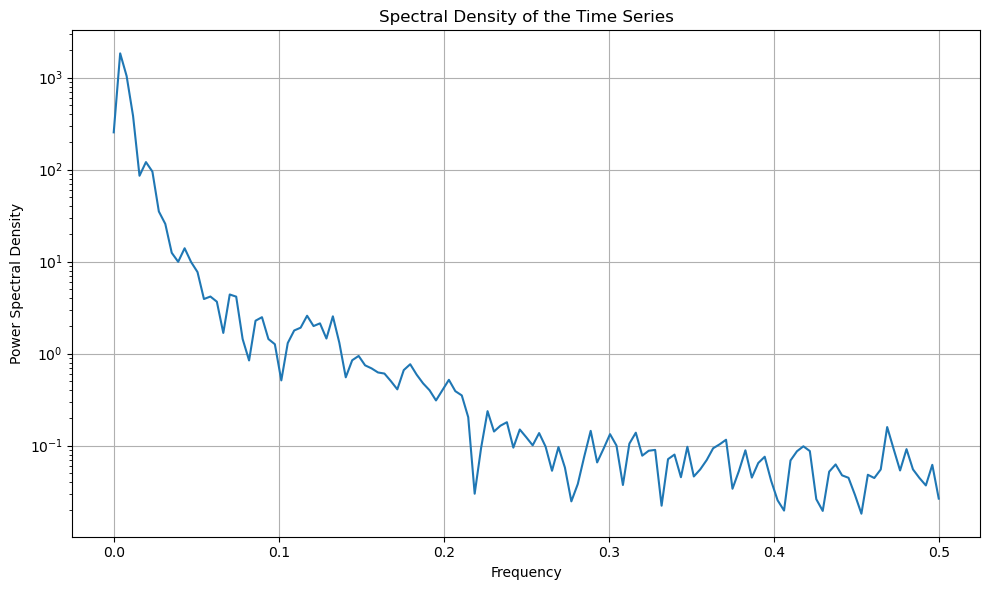

In [19]:
# Spectral density estimation (using Welch's method)
frequencies, Pxx = signal.welch(medical['Revenue'], fs=1)
plt.figure(figsize=[10, 6])
plt.semilogy(frequencies, Pxx)
plt.title('Spectral Density of the Time Series')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.tight_layout()
plt.show()

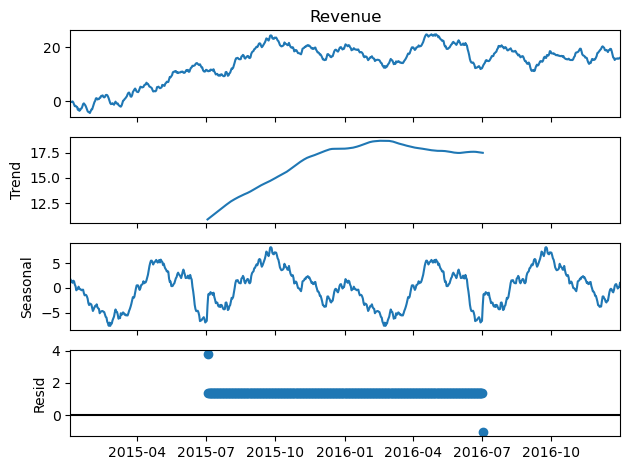

In [20]:
# Decompose the time series into trend, seasonal, and residual components
decomposed_data = seasonal_decompose(medical['Revenue'], model='additive', period=365)
decomposed_data.plot()
plt.show()

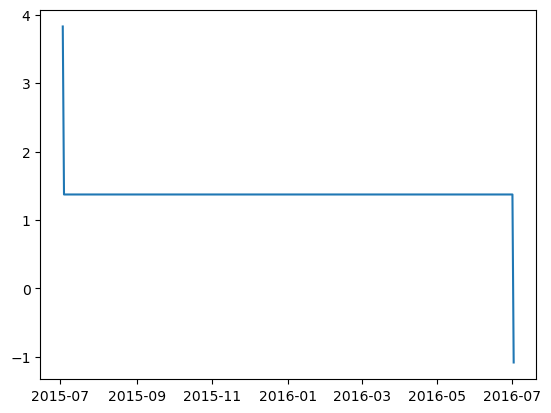

In [21]:
# Plot residual component of the data
plt.plot(decomposed_data.resid);

In [22]:
# Fit ARIMA model
model = ARIMA(train['Revenue'], order=(1, 0, 0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -408.001
Date:                Tue, 08 Oct 2024   AIC                            822.003
Time:                        21:32:08   BIC                            835.113
Sample:                    01-02-2015   HQIC                           827.112
                         - 08-07-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3965      6.975      1.634      0.102      -2.273      25.066
ar.L1          0.9986      0.002    431.226      0.000       0.994       1.003
sigma2         0.2344      0.014     16.310      0.0

In [23]:
# Extract the AR(1) coefficient and the constant
phi1 = results.params['ar.L1']
constant = results.params['const']

# Print the equation for AR(1) model
print(f"\nAR(1) Model Equation:")
print(f"X_t = {phi1:.4f} * (X_(t-1)) + {constant:.4f} + a_t")


AR(1) Model Equation:
X_t = 0.9986 * (X_(t-1)) + 11.3965 + a_t


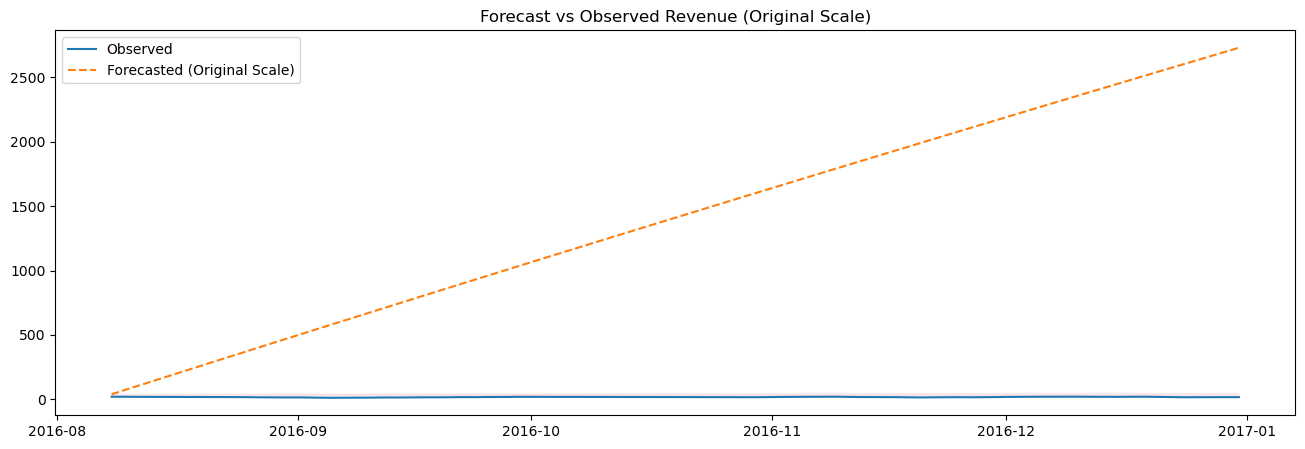

In [24]:
# Forecast future data based on differenced series
forecasted_diff = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=True)

# Convert forecasted differenced data back to the original scale by adding the last value of the training set
forecasted_original = forecasted_diff.predicted_mean.cumsum() + train['Revenue'].iloc[-1]

# Plot the forecasted and observed data
plt.figure(figsize=[16, 5])
plt.plot(test.index, test['Revenue'], label='Observed')
plt.plot(forecasted_original, label='Forecasted (Original Scale)', linestyle='dashed')
plt.fill_between(forecasted_diff.conf_int().index,
                 forecasted_diff.conf_int().iloc[:, 0] + train['Revenue'].iloc[-1],
                 forecasted_diff.conf_int().iloc[:, 1] + train['Revenue'].iloc[-1], color='pink', alpha=0.3)
plt.legend()
plt.title("Forecast vs Observed Revenue (Original Scale)")
plt.show()

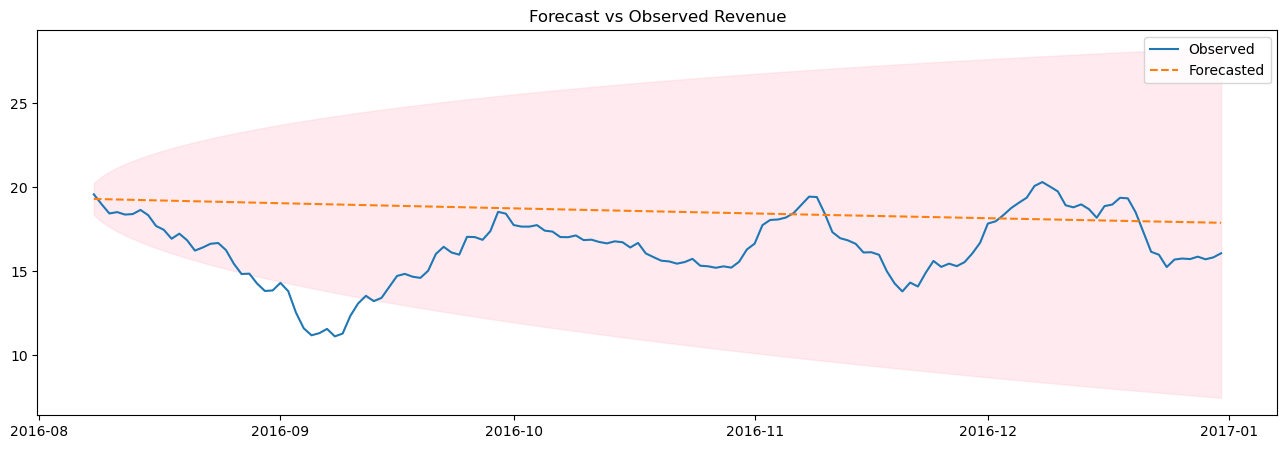

In [25]:
# Plot the forecasted and observed data
forecasted = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=True)
plt.figure(figsize=[16, 5])
plt.plot(test.index, test['Revenue'], label='Observed')
plt.plot(forecasted.predicted_mean, label='Forecasted', linestyle='dashed')
plt.fill_between(forecasted.conf_int().index,
                 forecasted.conf_int().iloc[:, 0],
                 forecasted.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("Forecast vs Observed Revenue")
plt.show()

In [26]:
# Calculate and show RMSE
rmse = mean_squared_error(test['Revenue'], forecasted.predicted_mean, squared=False)
print(f"The root mean squared error of this forecasting model is {round(rmse, 5)}")


The root mean squared error of this forecasting model is 3.04418


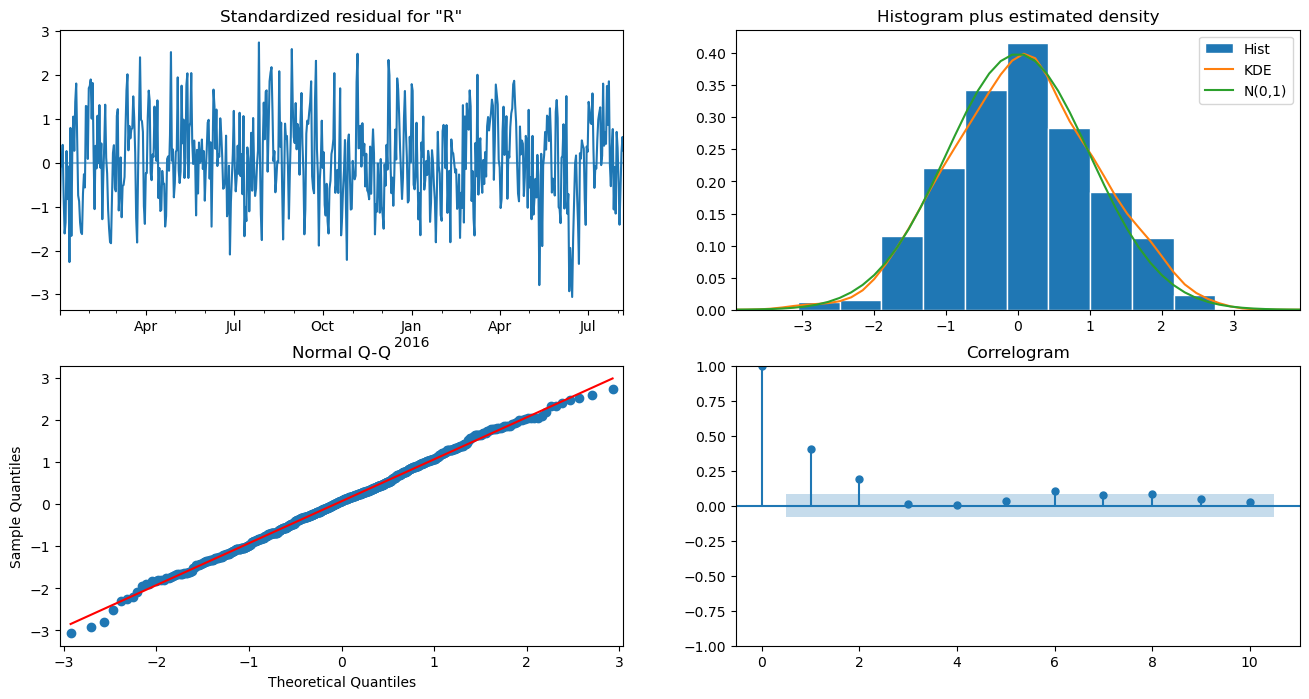

In [27]:
# Plot model diagnostics
results.plot_diagnostics(figsize=(16, 8))
plt.show()